# Predicting Housing Prices with Linear Regression using Python, pandas, and statsmodels

In this post, we'll walk through building linear regression models to predict housing prices resulting from economic activity. Topics covered will include:

&emsp;• [What is Regression](#What-is-Regression?) <br/>
&emsp;• [Variable Selection](#Variable-Selection) <br/>
&emsp;• [Reading in the Data with pandas](#Reading-in-the-Data-with-pandas) <br/>
&emsp;• [Ordinary Least Squares (OLS) Assumptions](#Ordinary-Least-Squares-Assumptions) <br/>
&emsp;• [Simple Linear Regression](#Simple-Linear-Regression) <br/>
&emsp;• [Regression Plots](#Regression-Plots) <br/>
&emsp;• [Multiple Linear Regression](#Multiple-Linear-Regression) <br/>
&emsp;• [Another Look at Partial Regression Plots](#Another-Look-at-Partial-Regression-Plots) <br/>
&emsp;• [Conclusion](#Conclusion) <br/>
&emsp;• [Navigating Pitfalls](#Navigating-Pitfalls) <br/>

Future posts will cover related topics such as exploratory analysis, regression diagnostics, and advanced regression modeling, but I wanted to jump right in so readers could get their hands dirty with data. 

## <b>What is Regression?</b>

Linear regression is a model that predicts a relationship of direct proportionality between the dependent variable (plotted on the vertical or Y axis) and the predictor variables (plotted on the X axis) that produces a straight line, like so: 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/440px-Linear_regression.svg.png"></img>

Linear regression will be discussed in greater detail as we move through the modeling process.

## <b>Variable Selection</b>

For our dependent variable we'll use `housing_price_index` (HPI), which measures price changes of residential housing.

For our predictor variables, we use our intuition to select drivers of macro- (or "big picture") economic activity, such as unemployment, interest rates, and gross domestic product (total productivity). For an explanation of our variables, including assumptions about how they impact housing prices, see <a href="https://github.com/tmthyjames/blog-post-resources/tree/patch-1/Housing%20Price%20Index%20Regression">here</a>. 

This data was imported from government sources including FRED, BEA, and BLS, all of which can be found <a href="https://github.com/tmthyjames/blog-post-resources/tree/patch-1/Housing%20Price%20Index%20Regression">here</a>.

## <b>Reading in the Data with <a href="http://pandas.pydata.org/">pandas</a></b>

Once we've downloaded the data, read it in using pandas' <b><a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html">`read_csv`</a></b> method.

In [21]:
import pandas as pd
# read in from csv using pd.read_csv
# be sure to use the file path where you saved the data
housing_price_index = pd.read_csv('/Users/tdobbins/Downloads/hpi/monthly-hpi.csv')
unemployment = pd.read_csv('/Users/tdobbins/Downloads/hpi/unemployment-macro.csv')
federal_funds_rate = pd.read_csv('/Users/tdobbins/Downloads/hpi/fed_funds.csv')
shiller = pd.read_csv('/Users/tdobbins/Downloads/hpi/shiller.csv')
gross_domestic_product = pd.read_csv('/Users/tdobbins/Downloads/hpi/gdp.csv')

Once we have the data, invoke pandas' <b><a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html">`merge`</a></b> method to join the data together in a single dataframe for analysis. Some data is reported monthly, others are reported quarterly. No worries. We `merge` the dataframes on a certain column so each row is in its logical place for measurement purposes. In this example, the best column to `merge` on is the `date` column. See below.

In [22]:
# merge dataframes into single dataframe by date
df = shiller.merge(housing_price_index, on='date')\
                    .merge(unemployment, on='date')\
                    .merge(federal_funds_rate, on='date')\
                    .merge(gross_domestic_product, on='date')

Let's get a quick look at our variables with pandas' <b><a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html">`head`</a></b> method. The headers in bold text represent the date and the variables we'll test for our model. Each row represents a different time period.

In [23]:
df.head()

,date,sp500,consumer_price_index,long_interest_rate,housing_price_index,total_unemployed,more_than_15_weeks,not_in_labor_searched_for_work,multi_jobs,leavers,losers,federal_funds_rate,total_expenditures,labor_force_pr,producer_price_index,gross_domestic_product
0,2011-01-01,1282.62,220.22,3.39,181.35,16.2,8393,2800,6816,6.5,60.1,0.17,5766.7,64.2,192.7,14881.3
1,2011-04-01,1331.51,224.91,3.46,180.80,16.1,8016,2466,6823,6.8,59.4,0.10,5870.8,64.2,203.1,14989.6
2,2011-07-01,1325.19,225.92,3.00,184.25,15.9,8177,2785,6850,6.8,59.2,0.07,5802.6,64.0,204.6,15021.1
3,2011-10-01,1207.22,226.42,2.15,181.51,15.8,7802,2555,6917,8.0,57.9,0.07,5812.9,64.1,201.1,15190.3
4,2012-01-01,1300.58,226.66,1.97,179.13,15.2,7433,2809,7022,7.4,57.1,0.08,5765.7,63.7,200.7,15291.0


Usually, the next step after gathering data would be exploratory analysis. Exploratory analysis is the part of the process where we analyze the variables (with plots and descriptive statistics) and figure out the best predictors of our dependent variable. For the sake of brevity, we'll skip the exploratory analysis. Keep in the back of your mind, though, that it's of utmost importance and that skipping it in the real world would preclude ever getting to the predictive section.

We'll use ordinary least squares (OLS), a basic yet powerful way to assess our model. 

## <b>Ordinary Least Squares Assumptions</b>

OLS measures the accuracy of a linear regression model.

OLS is built on assumptions which, if held, indicate the model may be the correct lens through which to interpret our data. If the assumptions don't hold, our model's conclusions lose their validity. Take extra effort to choose the right model to avoid <a href="http://www.kdnuggets.com/2016/11/analytic-personality-disorder.html">Auto-esotericism/Rube-Goldberg’s Disease</a>, as mentioned by <a href="http://www.kdnuggets.com/">KDnuggets</a>. 

Here are the OLS assumptions:<br/>

&emsp; 1) <b>Linearity</b>:  A linear relationship exists between the dependent and predictor variables. If no linear relationship exists, linear regression isn't the correct model to explain our data.<br/>

&emsp; 2) <b>No multicollinearity</b>:  Predictor variables are not collinear, i.e., they aren't highly correlated. If the predictors are highly correlated, try removing one or more of them. Since additional predictors are supplying redundant information, removing them shouldn't drastically reduce the <b style="background-color:#aec7e8;">Adj. R-squared</b> (see below).<br/>

&emsp; 3) <b>Zero conditional mean</b>:  The average of the distances (or residuals) between the observations and the trend line is zero. Some will be positive, others negative, but they won't be biased toward a set of values.

&emsp; 4) <b>Homoskedasticity</b>:  The certainty (or uncertainty) of our dependent variable is equal across all values of a predictor variable; that is, there is no pattern in the residuals. In statistical jargon, the variance is constant.<br/>

&emsp; 5) <b>No autocorrelation (serial correlation)</b>:  Autocorrelation is when a variable is correlated with itself across observations. For example, a stock price might be serially correlated if one day's stock price impacts the next day's stock price.<br/>

Let's begin modeling.

## <b>Simple Linear Regression</b>

Simple linear regression uses a single  predictor variable to explain a dependent variable. A simple linear regression equation is as follows:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/968be557dd22b1a2e536b8d22369cfdb37f58703"></img>

Where:

y = dependent variable

ß = <span style="background-color:#ffbb78;">correlation coefficient</span>

α = intercept (expected mean value of housing prices when our independent variable is zero)

x = predictor (or independent) variable used to predict Y

E = the error term, which accounts for the randomness that our model can't explain.

Using statsmodels' <b><a href="http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.html">`ols`</a></b> function, we construct our model setting `housing_price_index` as a function of `total_unemployed`. We assume that an increase in the total number of unemployed people will have downward pressure on housing prices. Maybe we're wrong, but we have to start somewhere!

The code below shows how to set up a simple linear regression model with `total_unemployment` as our predictor variable.

In [24]:
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols

# fit our model with .fit() and show results
# we use statsmodels' formula API to invoke the syntax below,
# where we write out the formula using ~
housing_model = ols("housing_price_index ~ total_unemployed", data=df).fit()
# summarize our model
housing_model_summary = housing_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
    housing_model_summary\
        .as_html()\
        .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;">  Adj. R-squared:    </th>')\
        .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')\
        .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')\
        .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')\
        .replace('<th>[95.0% Conf. Int.]</th>', '<th style="background-color:#ff9896;">[95.0% Conf. Int.]</th>')
)

Referring to the OLS regression results above, we'll offer a high-level explanation of a few metrics to understand the strength of our model: Adj. R-squared, coefficients, standard errors, and p-values.

To explain:

<b style="background-color:#aec7e8;">Adj. R-squared</b> indicates that 95% of housing prices can be explained by our predictor variable, `total_unemployed`.

The <b style="background-color:#ffbb78;">correlation coefficient (coef)</b> represents the change in the dependent variable resulting from a one unit change in the predictor variable, all other variables being held constant. In our model, a one unit increase in `total_unemployed` reduces `housing_price_index` by 8.33. In line with our <a href="https://github.com/tmthyjames/blog-post-resources/tree/patch-1/Housing%20Price%20Index%20Regression">assumptions</a>, an increase in unemployment appears to reduce housing prices.

The <b style="background-color:#c7e9c0;">standard error</b> measures the accuracy of `total_unemployed`'s coefficient by estimating the variation of the coefficient if the same test were run on a different sample of our population. Our standard error, 0.41, is low and therefore appears accurate.

The <b style="background-color:#bcbddc;">p-value</b> means the probability of an 8.33 decrease in `housing_price_index` due to a one unit increase in `total_unemployed` is 0%, assuming there is no relationship between the two variables. A low p-value indicates that the results are statistically significant, that is in general the p-value is less than 0.05.

The <b style="background-color:#ff9896;">confidence interval</b> is a range within which our coefficient is likely to fall. We can be 95% confident that `total_unemployed`'s coefficient will be within our confidence interval, [-9.185, -7.480].

Let's use statsmodels' <b><a href="http://statsmodels.sourceforge.net/0.5.0/generated/statsmodels.graphics.regressionplots.plot_regress_exog.html">`plot_regress_exog`</a></b> function to help us understand our model. 

## <b>Regression Plots</b>

Please see the four graphs below.

&emsp; 1) The "Y and Fitted vs. X" graph plots the dependent variable against our predicted values with a confidence interval. The inverse relationship in our graph indicates that `housing_price_index` and `total_unemployed` are negatively correlated, i.e., when one variable increases the other decreases.<br/>

&emsp; 2) The "Residuals versus `total_unemployed`" graph shows our model's errors versus the specified predictor variable. Each dot is an observed value; the line represents the mean of those observed values. Since there's no pattern in the distance between the dots and the mean value, the OLS assumption of homoskedasticity holds.<br/>

&emsp; 3) The "Partial regression plot" shows the relationship between `housing_price_index` and `total_unemployed`, taking in to account the impact of adding other independent variables on our existing `total_unemployed` coefficient. We'll see later how this same graph changes when we add more variables. 

&emsp; 4) The Component and Component Plus Residual (CCPR) plot is an extension of the partial regression plot, but shows where our trend line would lie after adding the impact of adding our other independent variables on our existing `total_unemployed` coefficient. More on this plot <a href="http://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/partresi.htm">here</a>.

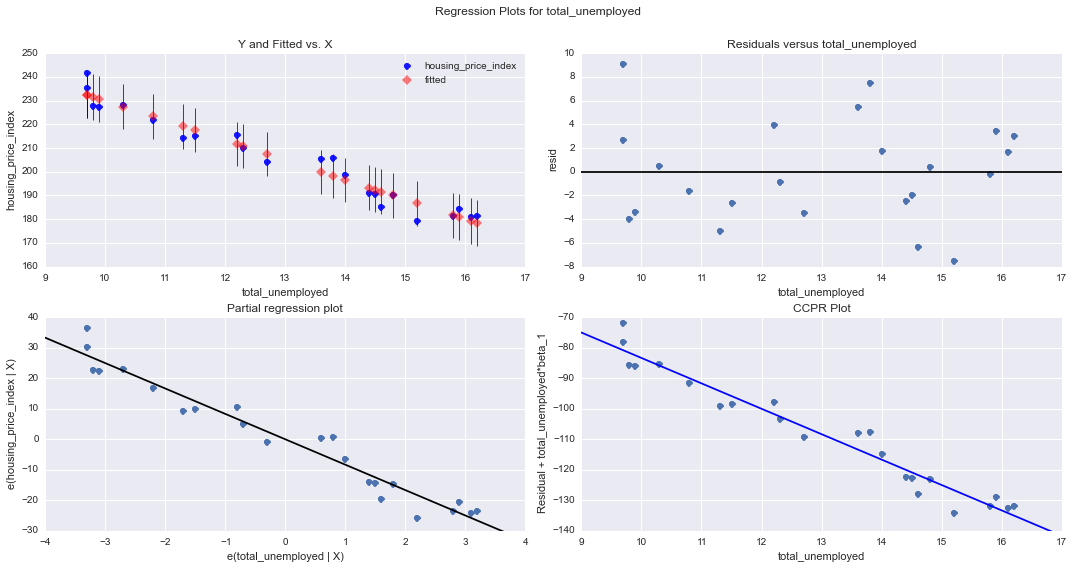

In [25]:
# this produces our four regression plots for total_unemployed

# plots the graphs inside the Jupyter/IPython Notebook
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# use figsize to adjust size, and pass in to plot_regress_exog
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(housing_model, "total_unemployed", fig=fig)

The next plot graphs our trend line (green), the observations (dots), and our confidence interval (red).

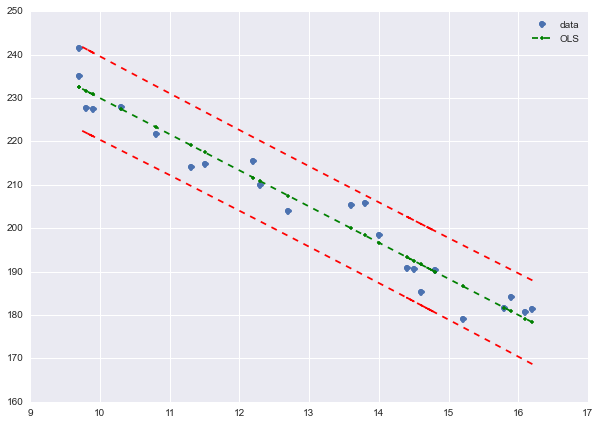

In [26]:
# this produces our trend line

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np

# predictor variable
x = df[['total_unemployed']]
# dependent variable
y = df[['housing_price_index']]

# retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(housing_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, housing_model.fittedvalues, 'g--.', label="OLS")
# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')
# plot legend
ax.legend(loc='best');

So far, our model looks decent. Let's add some more variables and see how `total_unemployed` reacts.

## <b>Multiple Linear Regression</b>

Mathematically, multiple linear regression is:

<img src="http://reliawiki.org/images/math/0/4/7/047b6637704da980c76306ebf9400781.png"></img>

We know that unemployment cannot entirely explain housing prices. To get a clearer picture of what influences housing prices, we add and test different variables and analyze the regression results to see which combinations of predictor variables satisfy OLS assumptions, while remaining intuitively appealing from an economic perspective.

We arrive at a model that contains the following variables: `fed_funds`, `consumer_price_index`, `long_interest_rate`, and `gross_domestic_product`, in addition to our original predictor, `total_unemployed`. 

Adding the new variables decreased the impact of `total_unemployed` on `housing_price_index` (variable explanations <a href="https://github.com/tmthyjames/blog-post-resources/tree/patch-1/Housing%20Price%20Index%20Regression">here</a>). `total_unemployed`'s impact is now more unpredictable (<b style="background-color:#c7e9c0;">standard error</b> increased from 0.41 to 2.399), and, since the <b style="background-color:#bcbddc;">p-value</b> is higher (from 0 to 0.943), less likely to influence housing prices. 

Although `total_unemployed` may be correlated with `housing_price_index`, our other predictors seem to capture more of the variation in housing prices. The real-world interconnectivity among our variables can't be encapsulated by a simple linear regression alone; a more robust model is required. This is why our multiple linear regression model's results change drastically when introducing new variables. 

That all our newly introduced variables are statistically significant at the 5% threshold, and that our coefficients follow our <a href="https://github.com/tmthyjames/blog-post-resources/tree/patch-1/Housing%20Price%20Index%20Regression">assumptions</a>, indicates that our multiple linear regression model is better than our simple linear model.

The code below sets up a multiple linear regression with our new predictor variables.

In [27]:
# again, invoke statsmodel's formula API using the below syntax
housing_model = ols("""housing_price_index ~ total_unemployed 
                                            + long_interest_rate 
                                            + federal_funds_rate
                                            + consumer_price_index 
                                            + gross_domestic_product""", data=df).fit()
# summarize our model
housing_model_summary = housing_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
    housing_model_summary\
        .as_html()\
        .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;">  Adj. R-squared:    </th>')\
        .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')\
        .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')\
        .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')\
        .replace('<th>[95.0% Conf. Int.]</th>', '<th style="background-color:#ff9896;">[95.0% Conf. Int.]</th>')
)

## <b>Another Look at Partial Regression Plots</b>

Now let's plot our partial regression graphs again to visualize how the `total_unemployed` variable was impacted by including the other predictors. The lack of trend in the partial regression plot for `total_unemployed` (in the figure below, upper right corner), relative to the <a href="#Regression-Plots">regression plot for `total_unemployed`</a> (above, lower left corner), indicates that total unemployment isn't as explanatory as the <a href="#Simple-Linear-Regression">first model suggested</a>. We also see that the observations from the latest variables are consistently closer to the trend line than the observations for `total_unemployment`, which reaffirms that `fed_funds`, `consumer_price_index`, `long_interest_rate`, and `gross_domestic_product` do a better job of explaining `housing_price_index`.

These partial regression plots reaffirm the superiority of our multiple linear regression model over our simple linear regression model.

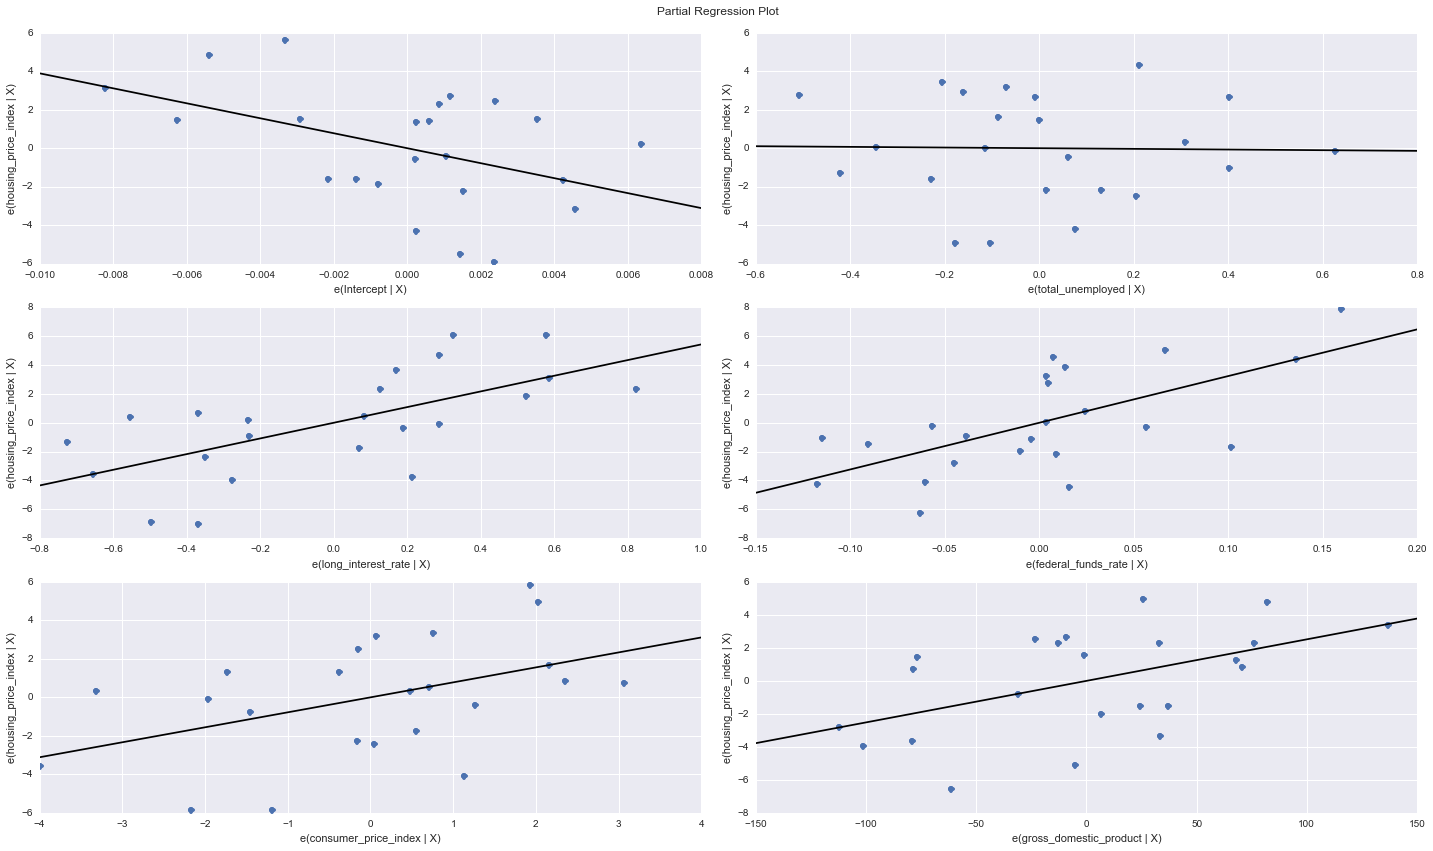

In [28]:
# this produces our six partial regression plots

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(housing_model, fig=fig)

## <b>Conclusion</b>

We have walked through setting up basic simple linear and multiple linear regression models to predict housing prices resulting from macroeconomic forces and how to assess the quality of a linear regression model on a basic level.

To be sure, explaining housing prices is a difficult problem. There are many more predictor variables that could be used. And causality could run the other way; that is, housing prices could be driving our macroeconomic variables; and even more complex still, these variables could be influencing each other simultaneously. 

I encourage you to dig into the data and tweak this model by adding and removing variables while remembering the importance of OLS assumptions and the regression results. 

<b>Most importantly, know that the modeling process, being based in science, is as follows: test, analyze, fail, and test some more.</b>

## <b>Navigating Pitfalls</b>

This post is an introduction to basic regression modeling, but experienced data scientists will find several flaws in our method and model, including:

&emsp;• <b>No Lit Review</b>:  While it's tempting to dive in to the modeling process, ignoring the existing body of knowledge is perilous. A lit review might have revealed that linear regression isn't the proper model to predict housing prices. It also might have improved variable selection. And spending time on a lit review at the outset can save a lot of time in the long run.

&emsp;• <b>Small sample size</b>:  Modeling something as complex as the housing market requires more than six years of data. Our small sample size is biased toward the events after the housing crisis and is not representative of long-term trends in the housing market.  

&emsp;• <b>Multicollinearity</b>:  A careful observer would've noticed the warnings produced by <a href="#Multiple-Linear-Regression">our model</a> regarding multicollinearity. We have two or more variables telling roughly the same story, overstating the value of each of the predictors.

&emsp;• <b>Autocorrelation</b>:  Autocorrelation occurs when past values of a predictor influence its current and future values. Careful reading of the <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Durbin-Watson</a> score would've revealed that autocorrelation is present in our model.

In a future post, we'll attempt to resolve these flaws to better understand the economic predictors of housing prices.